In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = torch.FloatTensor(data)
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[index:index+self.seq_len]
        y = self.data[index+self.seq_len:index+self.seq_len+self.pred_len]
        return x, y

In [3]:
class SimpleModel(nn.Module):
    def __init__(self, seq_len, pred_len):
        super(SimpleModel, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.1
        )
        self.fc = nn.Linear(64, pred_len)
        
    def forward(self, x):
        x = x.unsqueeze(-1)
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        predictions = self.fc(last_hidden)
        return predictions.unsqueeze(-1)

In [6]:

df = pd.read_csv('csv_files/realtime_generation_data.csv')
print("Veri Seti:")
print(df.head())

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['total']]).reshape(-1)

seq_len = 24    
pred_len = 12   
batch_size = 32

Veri Seti:
        Tarih   hour     total
0  01.12.2018  00:00  31782.78
1  01.12.2018  01:00  30016.48
2  01.12.2018  02:00  28713.42
3  01.12.2018  03:00  27838.91
4  01.12.2018  04:00  27621.64


In [7]:

dataset = TimeSeriesDataset(scaled_data, seq_len, pred_len)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

print(f"\nEğitim seti boyutu: {train_size}")
print(f"Test seti boyutu: {test_size}")

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Eğitim seti boyutu: 42077
Test seti boyutu: 10520


In [8]:

model = SimpleModel(seq_len=seq_len, pred_len=pred_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        batch_y = batch_y.unsqueeze(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            batch_y = batch_y.unsqueeze(-1)
            loss = criterion(outputs, batch_y)
            epoch_test_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    test_losses.append(epoch_test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}')

Epoch [10/100], Train Loss: 0.0020, Test Loss: 0.0018
Epoch [20/100], Train Loss: 0.0013, Test Loss: 0.0011
Epoch [30/100], Train Loss: 0.0009, Test Loss: 0.0009
Epoch [40/100], Train Loss: 0.0007, Test Loss: 0.0007
Epoch [50/100], Train Loss: 0.0007, Test Loss: 0.0006
Epoch [60/100], Train Loss: 0.0006, Test Loss: 0.0006
Epoch [70/100], Train Loss: 0.0006, Test Loss: 0.0005
Epoch [80/100], Train Loss: 0.0005, Test Loss: 0.0005
Epoch [90/100], Train Loss: 0.0005, Test Loss: 0.0005
Epoch [100/100], Train Loss: 0.0005, Test Loss: 0.0005


In [9]:

model.eval()
predictions = []
targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        predictions.extend(outputs.squeeze(-1).numpy())
        targets.extend(batch_y.numpy())

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1))

metrics = {
    'MSE': mean_squared_error(targets, predictions),
    'RMSE': np.sqrt(mean_squared_error(targets, predictions)),
    'MAE': mean_absolute_error(targets, predictions),
    'R2': r2_score(targets, predictions)
}

print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


Model Performance Metrics:
MSE: 739228.1875
RMSE: 859.7838134765625
MAE: 612.7705688476562
R2: 0.9753836989402771


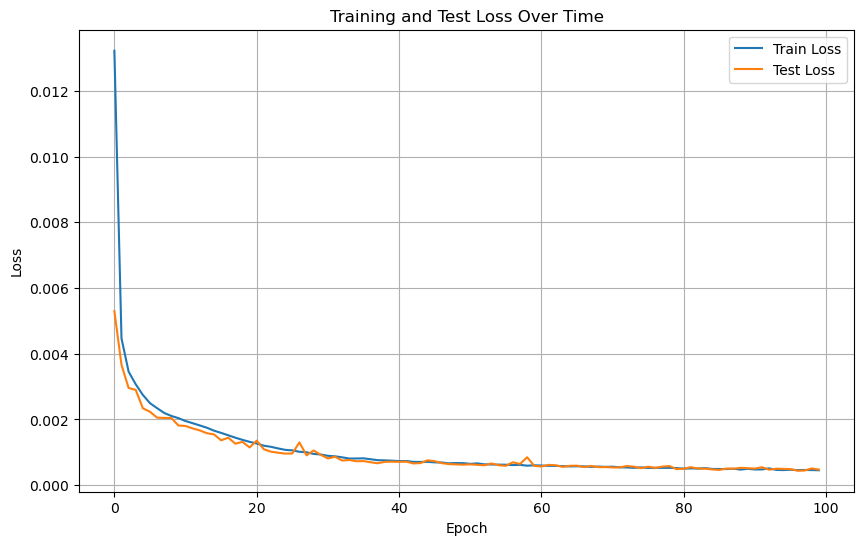

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

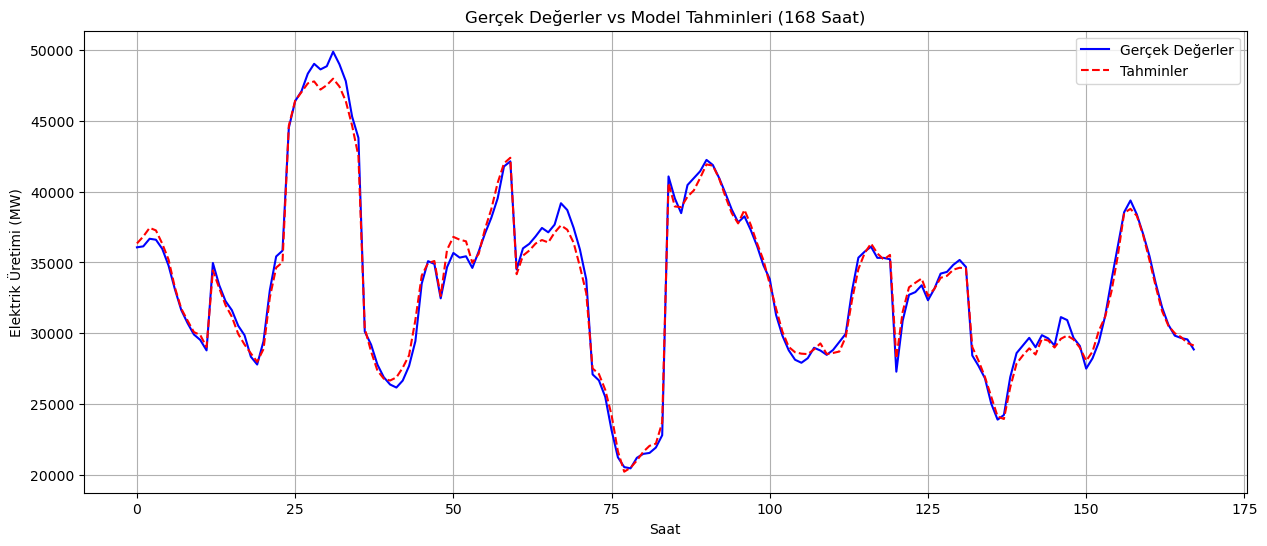

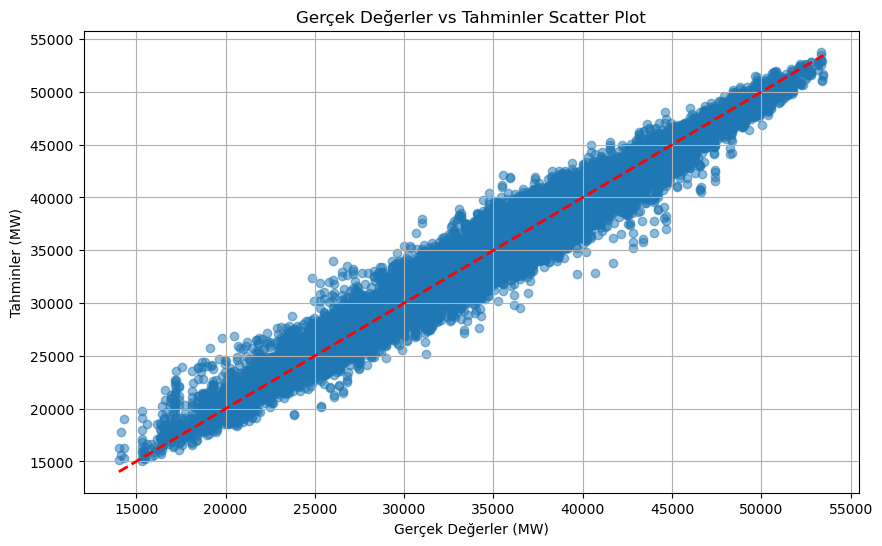

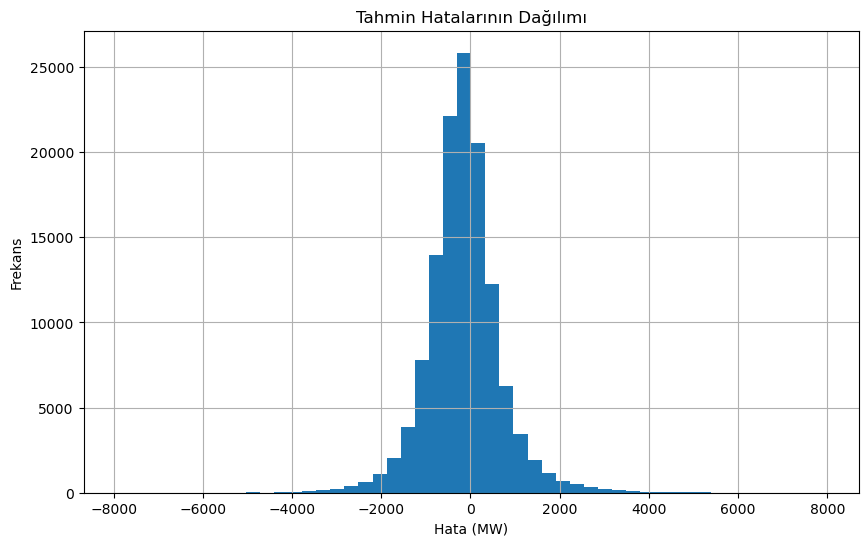


Tahmin İstatistikleri:
Ortalama Hata: -157.26 MW
Standart Sapma: 845.28 MW
Minimum Hata: -7882.86 MW
Maksimum Hata: 7912.21 MW


In [11]:

plt.figure(figsize=(15, 6))
n_samples = 168  

plt.plot(targets[:n_samples], label='Gerçek Değerler', color='blue')
plt.plot(predictions[:n_samples], label='Tahminler', color='red', linestyle='--')

plt.title('Gerçek Değerler vs Model Tahminleri (168 Saat)')
plt.xlabel('Saat')
plt.ylabel('Elektrik Üretimi (MW)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(targets, predictions, alpha=0.5)
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
plt.xlabel('Gerçek Değerler (MW)')
plt.ylabel('Tahminler (MW)')
plt.title('Gerçek Değerler vs Tahminler Scatter Plot')
plt.grid(True)
plt.show()

errors = predictions - targets
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Tahmin Hatalarının Dağılımı')
plt.xlabel('Hata (MW)')
plt.ylabel('Frekans')
plt.grid(True)
plt.show()

print("\nTahmin İstatistikleri:")
print(f"Ortalama Hata: {np.mean(errors):.2f} MW")
print(f"Standart Sapma: {np.std(errors):.2f} MW")
print(f"Minimum Hata: {np.min(errors):.2f} MW")
print(f"Maksimum Hata: {np.max(errors):.2f} MW")


IQR Yöntemi ile Outlier Analizi:
Alt Sınır: 19034.91
Üst Sınır: 50584.06
Outlier Sayısı: 219

Z-Score Yöntemi ile Outlier Analizi:
Outlier Sayısı: 130


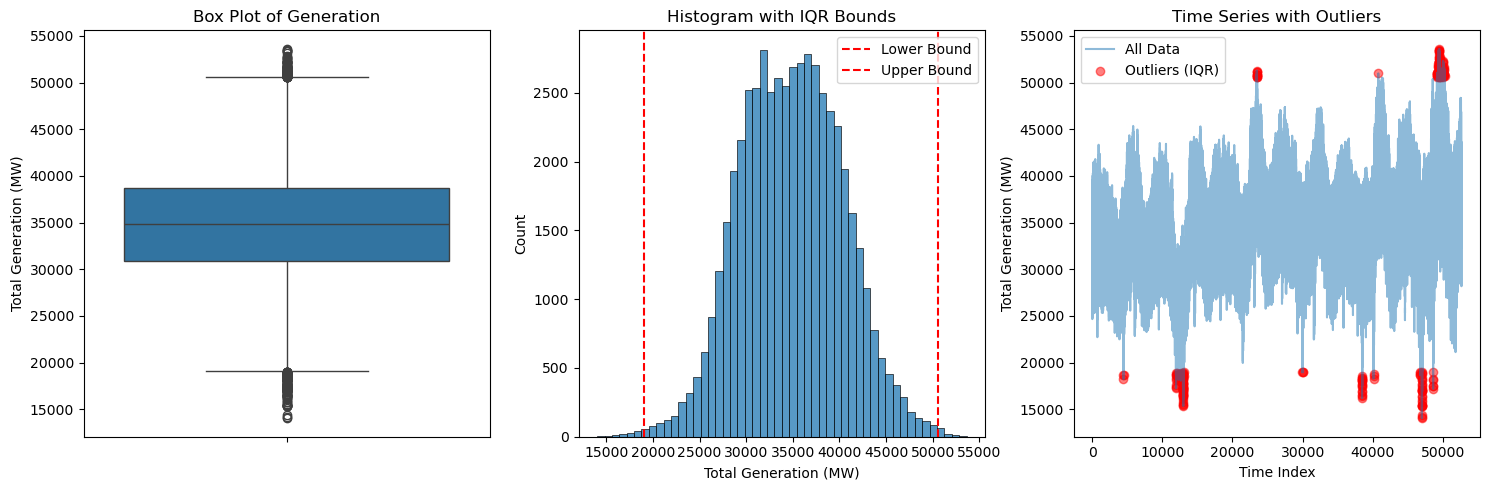


Outlier Örnekleri (IQR Yöntemi):
            Tarih   hour     total
4469   05.06.2019  05:00  18659.02
4470   05.06.2019  06:00  18203.66
4471   05.06.2019  07:00  18614.14
11936  11.04.2020  08:00  18883.50
11937  11.04.2020  09:00  18677.36

Saatlik Outlier Dağılımı:
hour
2      1
3      2
4      3
5      4
6      6
7     15
8     13
9     14
10    15
11    14
12    13
13     9
14    10
15     9
16    12
17    11
18     6
19    12
20    31
21    14
22     5
Name: count, dtype: int64


C:\Users\musta\AppData\Local\Temp\ipykernel_18980\2346561990.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  outliers_iqr['hour'] = pd.to_datetime(outliers_iqr['hour']).dt.hour
C:\Users\musta\AppData\Local\Temp\ipykernel_18980\2346561990.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_iqr['hour'] = pd.to_datetime(outliers_iqr['hour']).dt.hour


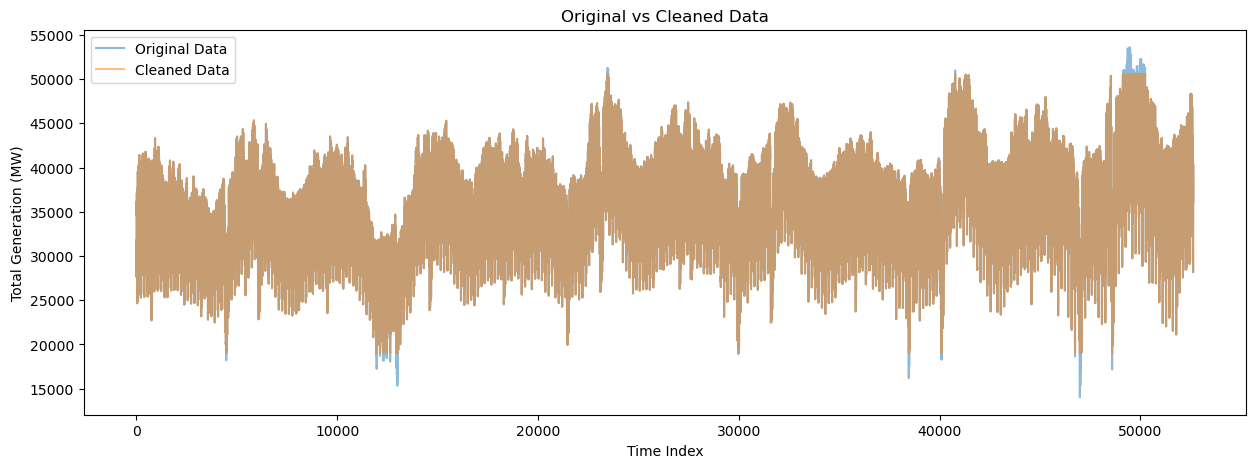


Temizleme Sonrası İstatistikler:

Orijinal Veri:
count    52632.000000
mean     34863.661611
std       5488.579954
min      14028.950000
25%      30865.840000
50%      34853.030000
75%      38753.130000
max      53614.340000
Name: total, dtype: float64

Temizlenmiş Veri:
count    52632.000000
mean     34865.778874
std       5473.202264
min      19034.905000
25%      30865.840000
50%      34853.030000
75%      38753.130000
max      50584.065000
Name: total, dtype: float64


In [13]:

import seaborn as sns
from scipy import stats

def detect_outliers(df, column='total'):
   

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    z_scores = stats.zscore(df[column])
    outliers_zscore = df[abs(z_scores) > 3]
    
    print(f"\nIQR Yöntemi ile Outlier Analizi:")
    print(f"Alt Sınır: {lower_bound:.2f}")
    print(f"Üst Sınır: {upper_bound:.2f}")
    print(f"Outlier Sayısı: {len(outliers_iqr)}")
    
    print(f"\nZ-Score Yöntemi ile Outlier Analizi:")
    print(f"Outlier Sayısı: {len(outliers_zscore)}")
    
    return outliers_iqr, outliers_zscore, (lower_bound, upper_bound)

outliers_iqr, outliers_zscore, bounds = detect_outliers(df)

plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.boxplot(y=df['total'])
plt.title('Box Plot of Generation')
plt.ylabel('Total Generation (MW)')

plt.subplot(132)
sns.histplot(data=df, x='total', bins=50)
plt.axvline(bounds[0], color='r', linestyle='--', label='Lower Bound')
plt.axvline(bounds[1], color='r', linestyle='--', label='Upper Bound')
plt.title('Histogram with IQR Bounds')
plt.xlabel('Total Generation (MW)')
plt.legend()

plt.subplot(133)
plt.plot(df['total'], alpha=0.5, label='All Data')
plt.scatter(outliers_iqr.index, outliers_iqr['total'], 
            color='red', label='Outliers (IQR)', alpha=0.5)
plt.title('Time Series with Outliers')
plt.xlabel('Time Index')
plt.ylabel('Total Generation (MW)')
plt.legend()

plt.tight_layout()
plt.show()

print("\nOutlier Örnekleri (IQR Yöntemi):")
print(outliers_iqr.head())

outliers_iqr['hour'] = pd.to_datetime(outliers_iqr['hour']).dt.hour
print("\nSaatlik Outlier Dağılımı:")
print(outliers_iqr['hour'].value_counts().sort_index())

def clean_outliers(df, bounds):
   
    df_cleaned = df.copy()
    df_cleaned['total'] = df_cleaned['total'].clip(bounds[0], bounds[1])
    return df_cleaned

df_cleaned = clean_outliers(df, bounds)

plt.figure(figsize=(15, 5))
plt.plot(df['total'], label='Original Data', alpha=0.5)
plt.plot(df_cleaned['total'], label='Cleaned Data', alpha=0.5)
plt.title('Original vs Cleaned Data')
plt.xlabel('Time Index')
plt.ylabel('Total Generation (MW)')
plt.legend()
plt.show()

print("\nTemizleme Sonrası İstatistikler:")
print("\nOrijinal Veri:")
print(df['total'].describe())
print("\nTemizlenmiş Veri:")
print(df_cleaned['total'].describe())

C:\Users\musta\AppData\Local\Temp\ipykernel_18980\2892662894.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_iqr['month'] = pd.to_datetime(outliers_iqr['Tarih'], format='%d.%m.%Y').dt.month


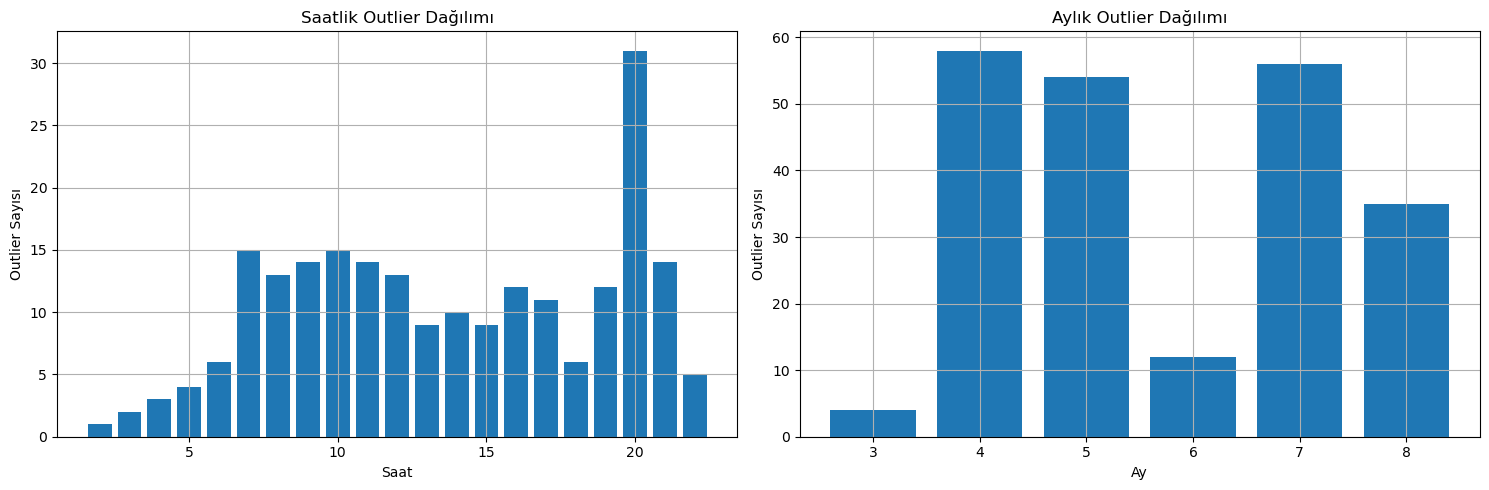


Outlier Değerlerin İstatistikleri:
count      219.000000
mean     31635.534110
std      16748.095888
min      14028.950000
25%      17497.545000
50%      18722.110000
75%      51006.985000
max      53614.340000
Name: total, dtype: float64

En çok outlier içeren 5 saat:
hour
2    1
3    2
4    3
5    4
6    6
Name: count, dtype: int64

En çok outlier içeren 5 ay:
month
3     4
4    58
5    54
6    12
7    56
Name: count, dtype: int64


In [16]:

plt.figure(figsize=(15, 5))

plt.subplot(121)
hourly_outliers = outliers_iqr['hour'].value_counts().sort_index()
plt.bar(hourly_outliers.index, hourly_outliers.values)
plt.title('Saatlik Outlier Dağılımı')
plt.xlabel('Saat')
plt.ylabel('Outlier Sayısı')
plt.grid(True)

plt.subplot(122)
df['month'] = pd.to_datetime(df['Tarih'], format='%d.%m.%Y').dt.month
outliers_iqr['month'] = pd.to_datetime(outliers_iqr['Tarih'], format='%d.%m.%Y').dt.month
monthly_outliers = outliers_iqr['month'].value_counts().sort_index()
plt.bar(monthly_outliers.index, monthly_outliers.values)
plt.title('Aylık Outlier Dağılımı')
plt.xlabel('Ay')
plt.ylabel('Outlier Sayısı')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nOutlier Değerlerin İstatistikleri:")
print(outliers_iqr['total'].describe())

print("\nEn çok outlier içeren 5 saat:")
print(hourly_outliers.head())
print("\nEn çok outlier içeren 5 ay:")
print(monthly_outliers.head())

In [17]:

df_cleaned = df.copy()
df_cleaned['total'] = df_cleaned['total'].clip(bounds[0], bounds[1])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_cleaned[['total']]).reshape(-1)

dataset = TimeSeriesDataset(scaled_data, seq_len, pred_len)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

print(f"\nTemizlenmiş veri ile eğitim seti boyutu: {train_size}")
print(f"Temizlenmiş veri ile test seti boyutu: {test_size}")

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model_cleaned = SimpleModel(seq_len=seq_len, pred_len=pred_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cleaned.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Eğitim
    model_cleaned.train()
    epoch_train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_cleaned(batch_x)
        batch_y = batch_y.unsqueeze(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # Değerlendirme
    model_cleaned.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model_cleaned(batch_x)
            batch_y = batch_y.unsqueeze(-1)
            loss = criterion(outputs, batch_y)
            epoch_test_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    test_losses.append(epoch_test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}')


Temizlenmiş veri ile eğitim seti boyutu: 42077
Temizlenmiş veri ile test seti boyutu: 10520
Epoch [10/100], Train Loss: 0.0028, Test Loss: 0.0025
Epoch [20/100], Train Loss: 0.0017, Test Loss: 0.0015
Epoch [30/100], Train Loss: 0.0013, Test Loss: 0.0012
Epoch [40/100], Train Loss: 0.0010, Test Loss: 0.0010
Epoch [50/100], Train Loss: 0.0009, Test Loss: 0.0009
Epoch [60/100], Train Loss: 0.0008, Test Loss: 0.0008
Epoch [70/100], Train Loss: 0.0008, Test Loss: 0.0011
Epoch [80/100], Train Loss: 0.0007, Test Loss: 0.0007
Epoch [90/100], Train Loss: 0.0007, Test Loss: 0.0007
Epoch [100/100], Train Loss: 0.0006, Test Loss: 0.0006



Temizlenmiş Veri ile Model Performance Metrics:
MSE: 632939.9375
RMSE: 795.5751953125
MAE: 552.2996215820312
R2: 0.9787173271179199


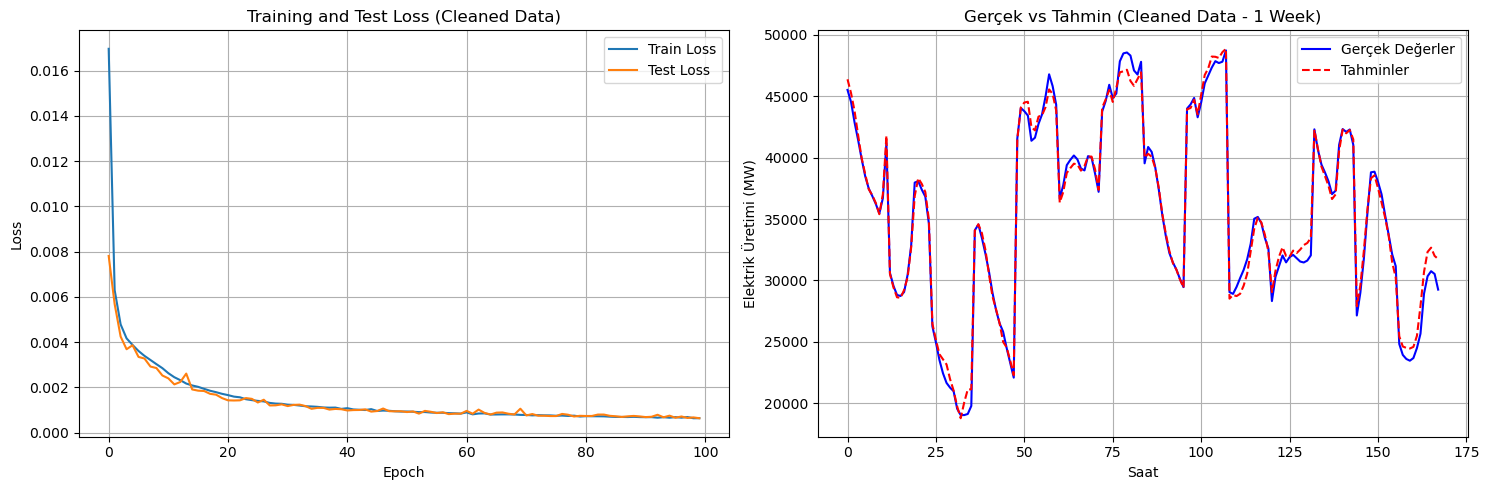

In [18]:

model_cleaned.eval()
predictions = []
targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model_cleaned(batch_x)
        predictions.extend(outputs.squeeze(-1).numpy())
        targets.extend(batch_y.numpy())

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1))

metrics_cleaned = {
    'MSE': mean_squared_error(targets, predictions),
    'RMSE': np.sqrt(mean_squared_error(targets, predictions)),
    'MAE': mean_absolute_error(targets, predictions),
    'R2': r2_score(targets, predictions)
}

print("\nTemizlenmiş Veri ile Model Performance Metrics:")
for metric, value in metrics_cleaned.items():
    print(f"{metric}: {value}")

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss (Cleaned Data)')
plt.legend()
plt.grid(True)

plt.subplot(122)
n_samples = 168 
plt.plot(targets[:n_samples], label='Gerçek Değerler', color='blue')
plt.plot(predictions[:n_samples], label='Tahminler', color='red', linestyle='--')
plt.title('Gerçek vs Tahmin (Cleaned Data - 1 Week)')
plt.xlabel('Saat')
plt.ylabel('Elektrik Üretimi (MW)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

c:\Users\musta\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


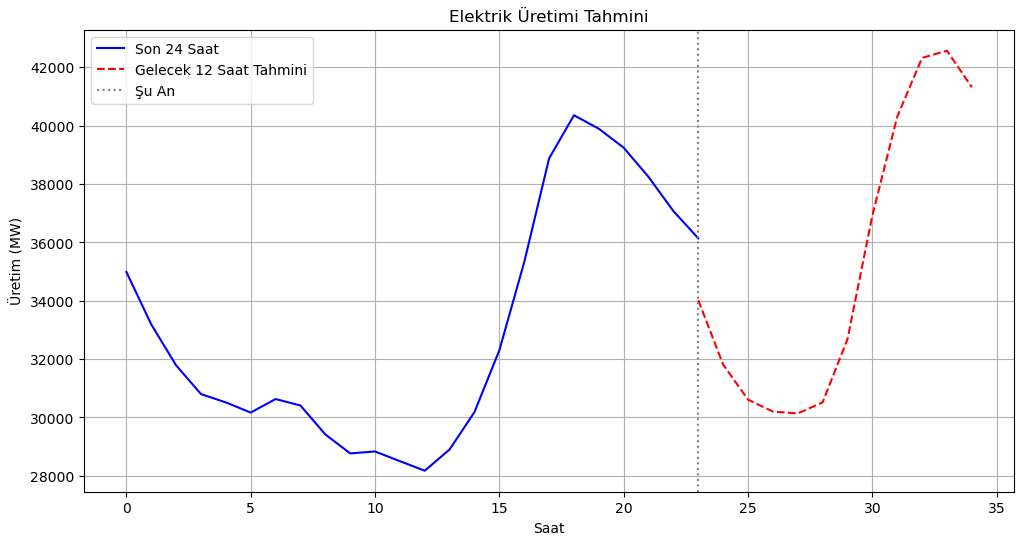


Son 24 Saat Ortalama Üretim: 33030.574583333335 MW
Gelecek 12 Saat Tahmin Edilen Ortalama Üretim: 35285.0 MW

Gelecek 12 Saat için Saatlik Tahminler:
Saat +1: 34017.59 MW
Saat +2: 31811.09 MW
Saat +3: 30610.79 MW
Saat +4: 30201.50 MW
Saat +5: 30139.16 MW
Saat +6: 30517.82 MW
Saat +7: 32683.89 MW
Saat +8: 36921.72 MW
Saat +9: 40306.89 MW
Saat +10: 42323.82 MW
Saat +11: 42568.40 MW
Saat +12: 41317.33 MW


In [20]:
import torch
import joblib

torch.save(model_cleaned.state_dict(), 'model_cleaned.pth')
joblib.dump(scaler, 'scaler.pkl')

def predict_generation(input_sequence, model, scaler, seq_len=24, pred_len=12):
   
    model.eval()
    
    scaled_input = scaler.transform(input_sequence.reshape(-1, 1))
    
    x = torch.FloatTensor(scaled_input).view(1, seq_len)
    
    with torch.no_grad():
        output = model(x)
        
    predictions = scaler.inverse_transform(output.squeeze(-1).numpy().reshape(-1, 1))
    
    return predictions

last_24_hours = df_cleaned['total'].iloc[-24:].values

future_predictions = predict_generation(last_24_hours, model_cleaned, scaler)

plt.figure(figsize=(12, 6))
plt.plot(range(24), last_24_hours, label='Son 24 Saat', color='blue')
plt.plot(range(23, 35), future_predictions, label='Gelecek 12 Saat Tahmini', 
         color='red', linestyle='--')
plt.axvline(x=23, color='gray', linestyle=':', label='Şu An')
plt.title('Elektrik Üretimi Tahmini')
plt.xlabel('Saat')
plt.ylabel('Üretim (MW)')
plt.legend()
plt.grid(True)
plt.show()

print("\nSon 24 Saat Ortalama Üretim:", last_24_hours.mean(), "MW")
print("Gelecek 12 Saat Tahmin Edilen Ortalama Üretim:", future_predictions.mean(), "MW")

print("\nGelecek 12 Saat için Saatlik Tahminler:")
for i, pred in enumerate(future_predictions):
    print(f"Saat +{i+1}: {pred[0]:.2f} MW")